In [1]:
from platform import python_version
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import user functions
import UserFunctions as uf
import Visualization as vi

# factor analysis mixed data types
import prince
from sklearn.decomposition import PCA
# seed
RANDOM_STATE = 1776
# notebook
notebook = '5V1_NumericToCategory'

# set seaborn theme
sns.set_theme()

# print versions
print("Numpy Version: " + np.__version__)
print("Pandas Version: " + pd.__version__)
print("Seaborn Version: " + sns.__version__)
print("Matplotlib Version: " + plt.matplotlib.__version__)
print("Python Version: " + python_version())
print("Prince Version: " + prince.__version__)

# adjust pandas display options to max
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# adjust pandas display options to ensure full display of content
pd.set_option('display.max_colwidth', None)

Numpy Version: 1.26.4
Pandas Version: 2.2.3
Seaborn Version: 0.13.2
Matplotlib Version: 3.9.2
Python Version: 3.9.20
Prince Version: 0.13.0


### Import Datasets

In [2]:
# data file
df = pd.read_pickle("../Data/Version1_DF5_cleanDF.pkl")

# remove columns
df_remove = pd.read_pickle("../Data/Version1_colRemove.pkl")

# data label
df_label = pd.read_pickle("../Data/Version1_colLabel.pkl")

# don columns
df_don = pd.read_pickle("../Data/Version1_DONColumn.pkl")

# can columns
df_can = pd.read_pickle("../Data/Version1_CANColumn.pkl")

# both columns
df_both = pd.read_pickle("../Data/Version1_BothColumn.pkl")

# nominal columns
df_nominal = pd.read_pickle("../Data/Version1_NominalColumn.pkl")

# ordinal columns
df_ordinal = pd.read_pickle("../Data/Version1_OrdinalColumn.pkl")

# data dictionary
df_dict = pd.read_pickle("../Data/Version1_FinalcolumnDefinition.pkl")

# import flat file
df_flat = pd.read_csv("../Data/flatfile.csv")

# checking for duplicated column name
df.columns[df.columns.duplicated()]

Index([], dtype='object')

In [3]:
print(f"Orginal Data file Shape: {df.shape}")
print(f"Label(s) Data rows: {len(df_label)}")
print(f"Remove Column(s) Data rows: {len(df_remove)}")
print(f"CAN Column(s) Data rows: {len(df_can)}")
print(f"DON Column(s) Data rows: {len(df_don)}")
print(f"Both Column(s) Data rows: {len(df_both)}")
print(f"Nominal Column(s) Data rows: {len(df_nominal)}")
print(f"Ordinal Column(s) Data rows: {len(df_ordinal)}")

Orginal Data file Shape: (15284, 259)
Label(s) Data rows: 15
Remove Column(s) Data rows: 25
CAN Column(s) Data rows: 114
DON Column(s) Data rows: 89
Both Column(s) Data rows: 16
Nominal Column(s) Data rows: 153
Ordinal Column(s) Data rows: 42


#### User Function(s)

In [14]:
def categoryContingency(group, label, observed=False, fill_value=0):
    """
    This function creates a contingency table for analyzing the frequency distribution 
    of a categorical label across different groups. It also calculates row-wise percentages
    for 'Dead' and 'Living' per category.
    """
    # Create contingency table
    data = df.groupby(group, observed=observed)[label].value_counts().unstack(fill_value=fill_value)
    
    # Get index name
    indexName = data.index.name
    
    # Add row totals
    data['Row Total'] = data.sum(axis=1)
    
    # Calculate row-wise percentages
    if 'Dead' in data.columns:
        # data['Dead %'] = (data['Dead'] / data['Row Total']) * 100
        data['Dead %'] = (data['Dead'] / (data['Dead'] + data['Living'])) * 100
    else:
        data['Dead %'] = 0

    if 'Living' in data.columns:
        # data['Living %'] = (data['Living'] / data['Row Total']) * 100
        data['Living %'] = (data['Living'] / (data['Dead'] + data['Living'])) * 100
    else:
        data['Living %'] = 0
    
    # Add column totals
    totals = data.sum().to_frame().T
    totals.index = ['Column Total']
    totals['Dead %'] = ''
    totals['Living %'] = ''
    
    # Concatenate the totals row to the original DataFrame
    df_with_totals = pd.concat([data, totals])
    
    # Set index name
    df_with_totals.index.name = indexName
    
    return df_with_totals


def EqualBinningNumeric(data, StrCol, binn, StrNewCol):
    # Perform qcut
    binned = pd.qcut(data[StrCol], q=binn)
    
    # Extract bin ranges and convert to string labels
    bin_ranges = binned.cat.categories
    labels = [f"({int(interval.left)}-{int(interval.right)})" for interval in bin_ranges]
    
    # Apply qcut with the bin ranges as labels
    data[StrNewCol] = pd.qcut(data[StrCol], q=binn, labels=labels)

    return data

### Examine Remove Features DataFrame

In [5]:
# get remove Features
removeCol = df_remove.remove.to_list()

# display
df[removeCol].head()

,ResidencyState_DON,ResidencyStateAtRegistration_CAN,ResidencyStateAtTransplant_CAN,VentricularDeviceTypeListing_CAN,VentricularDeviceTypeTransplant_CAN,VentricularDeviceBrandListing_CAN,VentricularDeviceBrandTransplant_CAN,PrimaryPaymentRegistration_CAN,PrimaryPaymentTransplant_CAN,PriorCardiacSurgeryTextType_CAN,StatusDays_1A,StatusDays_1B,StatusDays_2,StatusDays_1,StatusDays_A2,StatusDays_A3,StatusDays_A4,StatusDays_A5,StatusDays_A6,Status_DON,Status_CAN,StatusAfter_CAN,OtherMedsText1_DON,OtherMedsText2_DON,OtherMedsText3_DON
0,MA,NH,NH,None,Lvad,Unknown,Heartware HVAD,Public insurance - Medicaid,Free Care,NaN,118,126,0,0,0,0,0,0,0,Validated,Validated,Validated,NEOSYNEPHRINE,"FLAGYL, CEFTRIAXONE","ZOSYN, KCL"
1,TN,VA,VA,Lvad,Lvad,Heartmate II,Heartmate II,Public insurance - Medicaid,Private insurance,NaN,68,0,0,0,0,0,0,0,0,Validated,Validated,Validated,"VANC,FLAGYL","CEFEPIME,VEC","ALBU/ATRO,NEO"
2,AZ,IA,IA,Lvad,Lvad,Heartmate II,Heartmate II,Private insurance,Private insurance,LVAD,0,19,0,0,0,0,0,0,0,Validated,Validated,Validated,"AZITHROMYCIN, MEROPENEM, MICAFUNGIN","LEVAQUIN, VANCOMYCIN, MUCOMYST","ALBUTEROL, VECURONIUM"
3,CO,MO,MO,None,Lvad,Unknown,Heartware HVAD,Public insurance - Medicaid,Public insurance - Medicaid,NaN,31,367,0,0,0,0,0,0,0,Validated,Validated,Validated,NOREPINEPHRINE,CEFAZOLIN,NaN
4,MI,MI,MI,Lvad,Lvad,Heartware HVAD,Heartware HVAD,Private insurance,Private insurance,STENTS,9,281,0,0,0,0,0,0,0,Validated,Validated,Validated,"ANCEF, ALBUTEROL",NaN,NaN


In [6]:
# display & get dataypes 
uf.datatypeDF(df)
boolCol, catCol, objCol, numCol , otherCol = uf.datatypeDF(df, display=False)

Total Data feature count:  259

Boolean feature count: 0
Category feature count: 163
Numeric feature count: 82
Object feature count: 4
Other feature count: 10

Total feature count:  259


In [7]:
df[otherCol].head()

,AllocationBeginDate_CAN,RemovalWaitListDate_CAN,InitialWaitListDate_CAN,AdmissionDate_CAN,OrganRecoveryDate_DON,StatusDate_CAN,TransplantDate_CAN,CenterDischargeDate_CAN,AdmissionDate_DON,ReferralDate_DON
0,2016-02-12,2017-01-01,2016-02-12,2017-01-01,2017-01-01,2020-11-12,2017-01-01,2017-01-11,2016-12-28,2016-12-28
1,2016-10-25,2017-01-01,2016-10-25,2016-12-31,2017-01-01,2017-02-14,2017-01-01,2017-02-14,2016-12-28,2016-12-28
2,2012-10-03,2017-01-02,2016-12-14,2017-01-01,2017-01-02,2021-01-20,2017-01-02,2017-01-12,2016-12-28,2016-12-28
3,2014-09-18,2017-01-01,2014-09-18,2016-12-22,2017-01-01,2018-01-06,2017-01-01,2017-01-24,2016-12-21,2016-12-22
4,2016-03-02,2017-01-01,2016-03-02,2016-12-31,2017-01-01,2020-12-09,2017-01-01,2017-01-27,2016-12-30,2016-12-30


In [10]:
df_label

,label
0,FunctionalStatusFollowUp
1,DialysisPriorDischarge
2,AirwayDehiscencePostTransplant
3,AcuteRejectionEpisode
4,StrokePostTransplant
5,PacemakerPostTransplant
6,GraftFailed
7,GraftLifeSpanDay
8,LastFollowupNumber
9,TransplantStatus


In [16]:
df['OrganRecoveryYear_DON'] = df.OrganRecoveryDate_DON.dt.year.fillna(9999).astype(int)
df['InitialWaitListYear_CAN'] = df.InitialWaitListDate_CAN.dt.year.fillna(9999).astype(int)

In [12]:
categoryContingency(df['OrganRecoveryYear_DON'],'RecipientStatus')

RecipientStatus,Dead,Living,Lost to Follow Up,Re-transplanted,Unknown,Row Total,Dead %,Living %
OrganRecoveryYear_DON,,,,,,,,
2017,496.0,2279.0,9.0,12.0,0.0,2796.0,17.739628,81.509299
2018,411.0,2493.0,6.0,23.0,0.0,2933.0,14.012956,84.998295
2019,387.0,2636.0,1.0,15.0,0.0,3039.0,12.734452,86.739059
2020,337.0,2843.0,0.0,13.0,0.0,3193.0,10.554338,89.038522
2021,192.0,2729.0,0.0,12.0,377.0,3310.0,5.800604,82.44713
9999,0.0,0.0,0.0,0.0,13.0,13.0,0.0,0.0
Column Total,1823.0,12980.0,16.0,75.0,390.0,15284.0,,


In [17]:
categoryContingency(df['InitialWaitListYear_CAN'],'RecipientStatus')

RecipientStatus,Dead,Living,Lost to Follow Up,Re-transplanted,Unknown,Row Total,Dead %,Living %
InitialWaitListYear_CAN,,,,,,,,
2011,1.0,19.0,0.0,0.0,0.0,20.0,5.0,95.0
2012,6.0,38.0,0.0,1.0,0.0,45.0,13.636364,86.363636
2013,9.0,67.0,0.0,0.0,0.0,76.0,11.842105,88.157895
2014,31.0,144.0,1.0,0.0,0.0,176.0,17.714286,82.285714
2015,67.0,300.0,0.0,1.0,0.0,368.0,18.256131,81.743869
2016,187.0,912.0,5.0,7.0,0.0,1111.0,17.015469,82.984531
2017,436.0,2191.0,5.0,12.0,0.0,2644.0,16.596879,83.403121
2018,357.0,2363.0,4.0,24.0,3.0,2751.0,13.125,86.875
2019,358.0,2494.0,1.0,8.0,12.0,2873.0,12.552595,87.447405


### Wrangle Dataset

In [5]:
df_dict[df_dict.featureName.isin(['RecipientStatus','TransplantStatus'])]

,featureName,desc,form,formSection,dataType,labelSAS,COMMENT,Information
213,TransplantStatus,"Boolean Most Recent Patient Status (based on composite death date) (1=Dead, 0=Alive)",TRR/TRF-CALCULATED,PATIENT STATUS,Nominal - NUM,Boolean Most Recent Patient Status (based on composite death date),Unknown,Label - {'PSTATUS': 'TransplantStatus'} - ** 999: Unknown **
228,RecipientStatus,"RECIPIENT STATUS(Died, ReTX, Lost, Alive)",TRR/TRF-CALCULATED,PATIENT STATUS,Nominal - CHAR,"PAT/GRF STATUS: DIED, RETX, LOST, ALIVE",Unknown,SASAnalysisFormat: PXSTAT - Label - {'PX_STAT': 'RecipientStatus'} - ** U: Unknown **


In [10]:
# remove labels
removeCol = df_label.label[(~df_label.label.isin(['RecipientStatus']))].to_list()

# house keeping
df, df_dict, df_remove, df_label, df_can, df_don, df_both, df_ordinal,  df_nominal = uf.HouseKeeping(df, removeCol, df_dict, df_remove, \
                                                                                                     df_label, df_can, df_don, df_both,\
                                                                                                     df_ordinal,  df_nominal, notebook)

Data Dictionary Updated.
Remove row(s) from df_remove DataFrame.
Remove row(s) from df_label DataFrame.
Remove row(s) from df_can DataFrame.
Remove row(s) from df_don DataFrame.
Remove row(s) from df_both DataFrame.
Remove row(s) from df_ordinal DataFrame.
Remove row(s) from df_nominal DataFrame.

Removed Features:['AcuteRejection', 'AcuteRejectionEpisode', 'AirwayDehiscencePostTransplant', 'DialysisPriorDischarge', 'FunctionalStatusFollowUp', 'FunctionalStatusFollowUp_Combined', 'GraftFailed', 'GraftLifeSpanDay', 'GraftStatus', 'LastFollowupNumber', 'LengthOfStay', 'PacemakerPostTransplant', 'RejectionTreatmentWithinOneYear', 'StrokePostTransplant', 'TransplantStatus', 'TransplantSurvivalDay']

Total rows before: 15,284 & columns: 250
Total rows after: 15,284 & columns: 234


In [11]:
# get all category features
catCol = (df_nominal.nominal.to_list()) + (df_ordinal.ordinal.to_list())

# convert datatype to category
df = uf.toCategory(df, catCol)

In [12]:
# display DataType info
uf.datatypeDF(df)
_, catCol, _, numCol, _ = uf.datatypeDF(df, display=False)

Total Data feature count:  234

Boolean feature count: 0
Category feature count: 186
Numeric feature count: 48
Object feature count: 0
Other feature count: 0

Total feature count:  234


#### Examine Data

In [13]:
# get all label featuresl
labelCol = (sorted(df_label.label.to_list()))

# non label category features
categoryCol = (set(catCol) - set(labelCol))

In [15]:
print(sorted(numCol))

['Age_CAN', 'Age_DON', 'Age_Listing_CAN', 'Age_Sum', 'BMI_CAN', 'BMI_DON', 'BloodPH_DON', 'BloodUreaNitrogenLevel_DON', 'CPRA_Peak', 'CPRA_Recent', 'CreatinineListing_CAN', 'CreatinineTransplant_CAN', 'Creatinine_DON', 'Creatinine_Sum', 'DistanceFromDonorHospitaltoTXCenter', 'HeightCm_CAN', 'HeightCm_DON', 'HeightCm_Sum', 'Hematocrit_DON', 'HemodynamicsRegistration_CO_CAN', 'HemodynamicsRegistration_PA_DIA_CAN', 'HemodynamicsRegistration_PA_MN_CAN', 'HemodynamicsRegistration_PCW_CAN', 'HemodynamicsRegistration_SYS_CAN', 'HemodynamicsTransplant_CO_CAN', 'HemodynamicsTransplant_PA_DIA_CAN', 'HemodynamicsTransplant_PA_MN_CAN', 'HemodynamicsTransplant_PCW_CAN', 'HemodynamicsTransplant_SYS_CAN', 'Hemodynamics_CO_CAN', 'Hemodynamics_PA_MN_CAN', 'IschemicTimeHour_DON', 'LV_EjectionFractionPercent_DON', 'Level_SGOT_ALT_DON', 'Level_SGOT_AST_DON', 'Level_SGOT_DON_Ratio', 'LungPF_Ratio_DON', 'LungPO2_DON', 'LungPO2_FIO2_DON', 'PCO2_DON', 'TotalBilirubin_CAN', 'TotalBilirubin_DON', 'TotalBilirubi

In [22]:
df = EqualBinningNumeric(df, 'Age_CAN', 5, 'Age_BIN_5_CAN').copy()

In [24]:
df = EqualBinningNumeric(df, 'Age_DON', 5, 'Age_BIN_5_DON').copy()

In [33]:
categoryContingency(df['BloodPH_DON'],'RecipientStatus')

RecipientStatus,Dead,Living,Lost to Follow Up,Re-transplanted,Unknown,Row Total,Dead %,Living %
BloodPH_DON,,,,,,,,
6.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,100.0
6.98,1.0,0.0,0.0,0.0,0.0,1.0,100.0,0.0
7.0,1.0,6.0,0.0,0.0,0.0,7.0,14.285714,85.714286
7.01,0.0,1.0,0.0,0.0,0.0,1.0,0.0,100.0
7.03,0.0,1.0,0.0,0.0,0.0,1.0,0.0,100.0
7.05,0.0,1.0,0.0,1.0,0.0,2.0,0.0,50.0
7.08,0.0,3.0,0.0,0.0,0.0,3.0,0.0,100.0
7.1,0.0,2.0,0.0,0.0,0.0,2.0,0.0,100.0
7.12,0.0,1.0,0.0,0.0,0.0,1.0,0.0,100.0


In [ ]:
categoryContingency(df['Age_BIN_5_CAN'],'RecipientStatus')

In [ ]:
vi.categoricalFeaturesCountPlot(df, ['Age_Bin'],figsize=(15, 4), tickFont=13, titleFont=12)

In [89]:
df[['Age_CAN','Age_Bin']][df.Age_CAN == 59].sample(5)

,Age_CAN,Age_Bin
14556,59,(53-59)
8653,59,(53-59)
6871,59,(53-59)
12249,59,(53-59)
14274,59,(53-59)


#### Category Infomation

In [17]:
for col in categoryCol:
    data = categoryContingency(col,'RecipientStatus')
    print(data.to_string(index=True, header=True, line_width=200), "\n")

RecipientStatus                Dead   Living  Lost to Follow Up  Re-transplanted  Unknown  Row Total     Dead %   Living %
VentilatorRegistratyion_CAN                                                                                               
0                            1768.0  12798.0               15.0             75.0    385.0    15041.0  11.754538  85.087428
1                              55.0    182.0                1.0              0.0      5.0      243.0  22.633745  74.897119
Column Total                 1823.0  12980.0               16.0             75.0    390.0    15284.0                       

RecipientStatus       Dead   Living  Lost to Follow Up  Re-transplanted  Unknown  Row Total     Dead %   Living %
UrineInfection_DON                                                                                               
0                   1592.0  11446.0               14.0             62.0    365.0    13479.0  11.810965  84.917279
1                    230.0   1533.0      

In [20]:
print(sorted(numCol))

['Age_CAN', 'Age_DON', 'Age_Listing_CAN', 'Age_Sum', 'BMI_CAN', 'BMI_DON', 'BloodPH_DON', 'BloodUreaNitrogenLevel_DON', 'CPRA_Peak', 'CPRA_Recent', 'CreatinineListing_CAN', 'CreatinineTransplant_CAN', 'Creatinine_DON', 'Creatinine_Sum', 'DistanceFromDonorHospitaltoTXCenter', 'HeightCm_CAN', 'HeightCm_DON', 'HeightCm_Sum', 'Hematocrit_DON', 'HemodynamicsRegistration_CO_CAN', 'HemodynamicsRegistration_PA_DIA_CAN', 'HemodynamicsRegistration_PA_MN_CAN', 'HemodynamicsRegistration_PCW_CAN', 'HemodynamicsRegistration_SYS_CAN', 'HemodynamicsTransplant_CO_CAN', 'HemodynamicsTransplant_PA_DIA_CAN', 'HemodynamicsTransplant_PA_MN_CAN', 'HemodynamicsTransplant_PCW_CAN', 'HemodynamicsTransplant_SYS_CAN', 'Hemodynamics_CO_CAN', 'Hemodynamics_PA_MN_CAN', 'IschemicTimeHour_DON', 'LV_EjectionFractionPercent_DON', 'Level_SGOT_ALT_DON', 'Level_SGOT_AST_DON', 'Level_SGOT_DON_Ratio', 'LungPF_Ratio_DON', 'LungPO2_DON', 'LungPO2_FIO2_DON', 'PCO2_DON', 'TotalBilirubin_CAN', 'TotalBilirubin_DON', 'TotalBilirubi

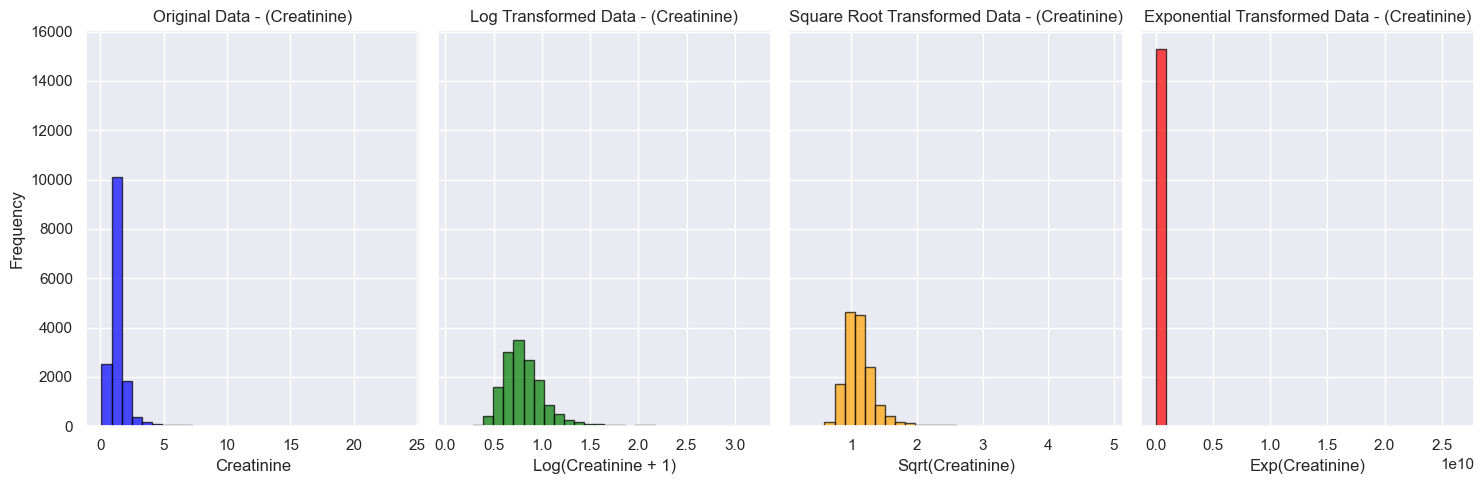

In [21]:
vi.transformPlots(df.CreatinineListing_CAN, txt= 'Creatinine', bins=30, figsize=(15, 5))

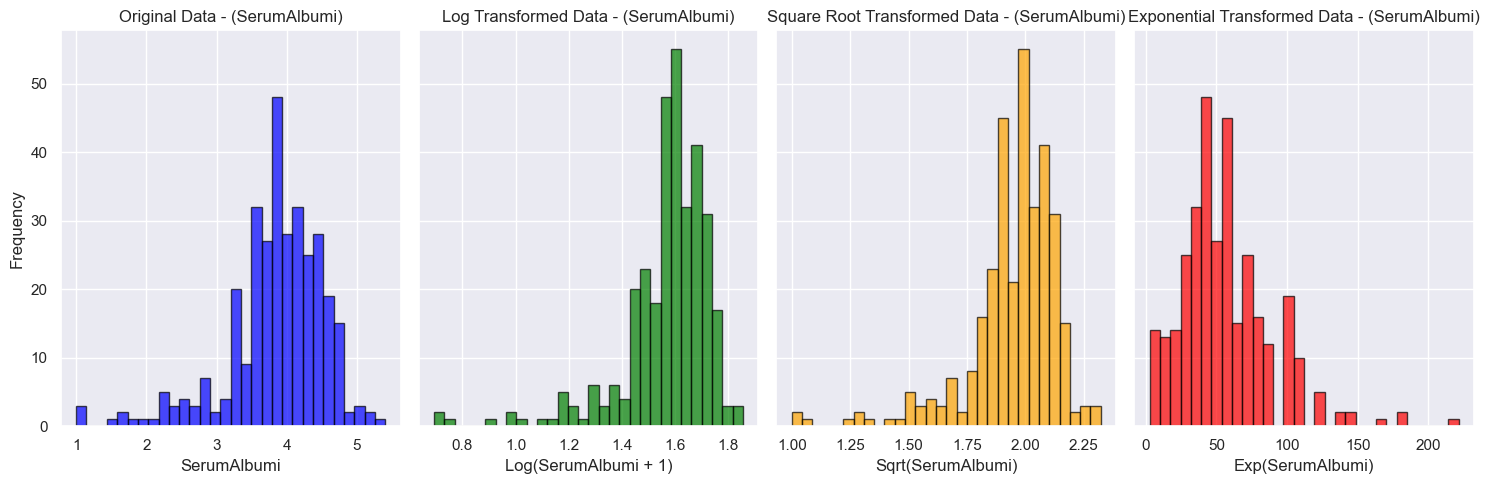

In [22]:
vi.transformPlots(df.TotalSerumAlbumin_CAN, txt= 'SerumAlbumi', bins=30, figsize=(15, 5))

/opt/homebrew/Caskroom/miniconda/base/envs/survival_env/lib/python3.9/site-packages/matplotlib/ticker.py:2119: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


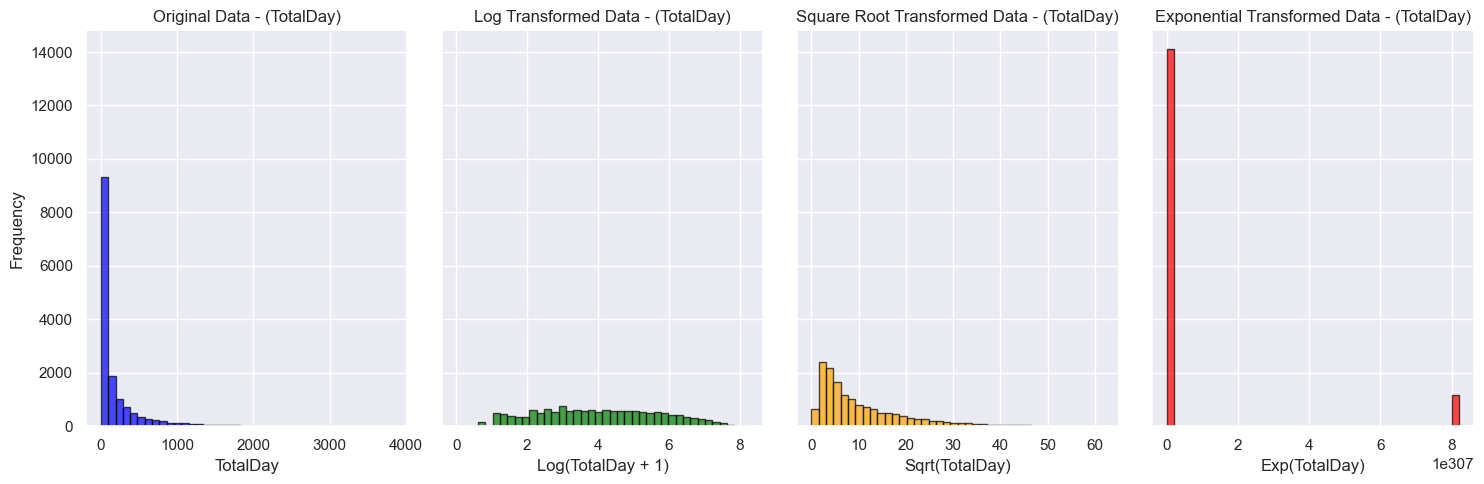

In [27]:
vi.transformPlots(df.TotalDayWaitList_CAN, txt= 'TotalDay', bins=40, figsize=(15, 5))

<Axes: >

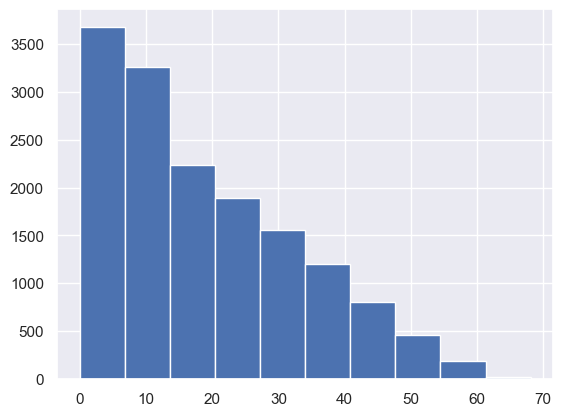

In [39]:
np.square(np.log(df.TotalDayWaitList_CAN + 1)).hist()

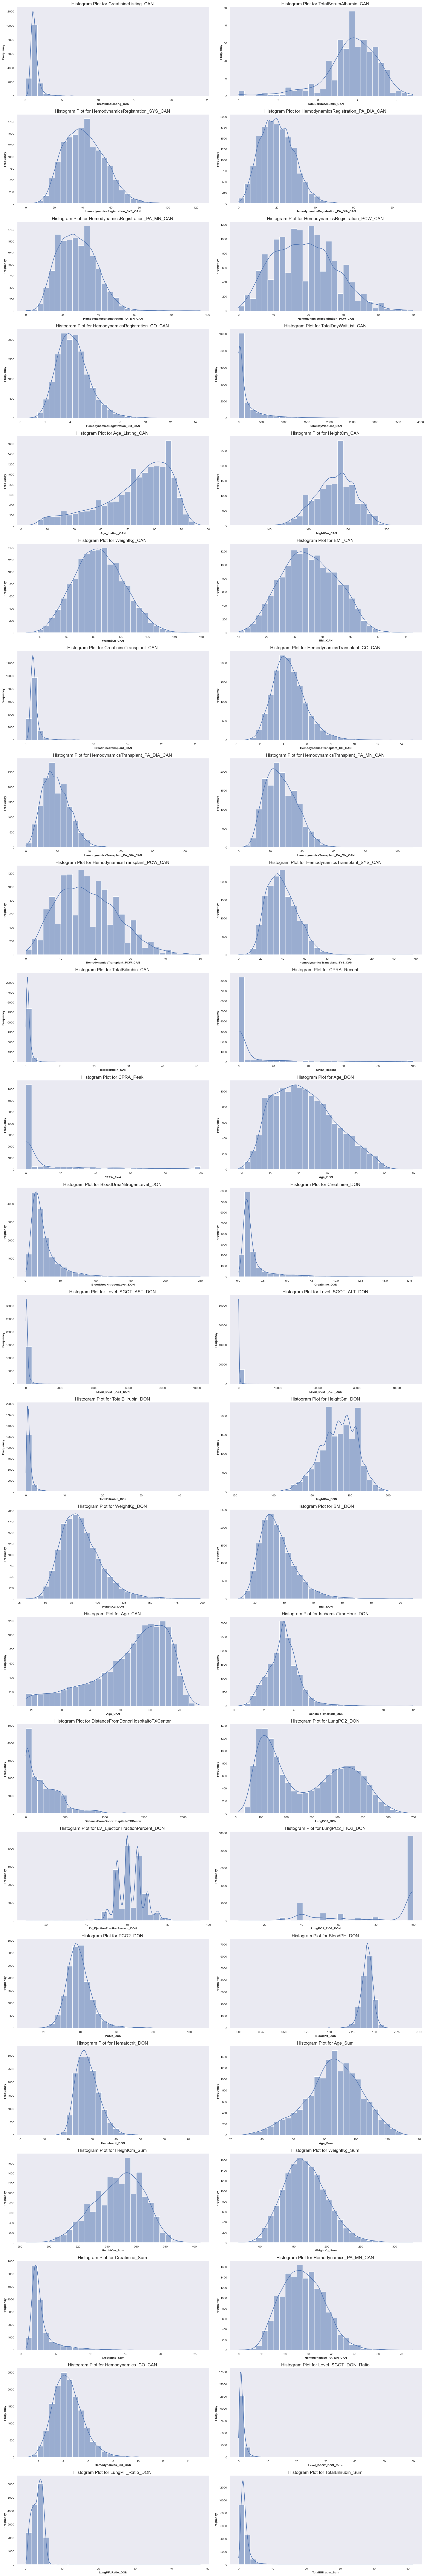

In [24]:
vi.histogramPlot(df, numCol, bins=30)

In [30]:
df.CreatinineListing_CAN.min(),df.CreatinineListing_CAN.quantile(0.25),df.CreatinineListing_CAN.quantile(0.50),df.CreatinineListing_CAN.quantile(0.75), df.CreatinineListing_CAN.max()

(0.08, 0.96, 1.2, 1.5, 24.0)

In [31]:
df.TotalSerumAlbumin_CAN.min(),df.TotalSerumAlbumin_CAN.quantile(0.25),df.TotalSerumAlbumin_CAN.quantile(0.50),df.TotalSerumAlbumin_CAN.quantile(0.75), df.TotalSerumAlbumin_CAN.max()

(1.0, 3.6, 3.9, 4.3, 5.4)

In [20]:
df[numCol].describe().T

,count,mean,std,min,25%,50%,75%,max
CreatinineListing_CAN,15284.0,1.393200,1.039604,0.080000,0.960000,1.200000,1.500000,24.000000
TotalSerumAlbumin_CAN,328.0,3.841768,0.686162,1.000000,3.600000,3.900000,4.300000,5.400000
HemodynamicsRegistration_SYS_CAN,14732.0,41.364309,14.271316,0.000000,31.000000,40.000000,51.000000,123.000000
HemodynamicsRegistration_PA_DIA_CAN,14722.0,20.239112,8.730090,0.000000,14.000000,20.000000,26.000000,91.000000
HemodynamicsRegistration_PA_MN_CAN,14652.0,28.203341,10.253912,0.000000,20.000000,28.000000,35.000000,96.000000
HemodynamicsRegistration_PCW_CAN,13951.0,18.800552,8.801433,0.000000,12.000000,18.000000,25.000000,50.000000
HemodynamicsRegistration_CO_CAN,14443.0,4.258799,1.334269,0.450000,3.330000,4.100000,5.000000,14.400000
TotalDayWaitList_CAN,15284.0,198.363714,354.386797,0.000000,13.000000,52.000000,215.000000,3835.000000
Age_Listing_CAN,15284.0,52.971670,12.957176,12.000000,46.000000,56.000000,63.000000,77.000000
HeightCm_CAN,15284.0,173.798476,10.095670,124.500000,167.600000,175.300000,180.300000,213.400000
